
# B.8. Pre-Calibration Tutorial for Coupled Human-Water Systems Modeling

This notebook demonstrates a precalibration workflow for coupled human-water systems modeling. 

To avoid long runtimes, we provide pre-generated simulation results so users can focus on experiencing the precalibration workflow and analyzing the outcomes. The simulation code is provided at the end of this notebook, allowing users to run the model on their own local machine if preferred.

The code block below is to setup the environment.

In [8]:
# Install and load packages

# Install packages if not already installed
#!pip install pathnavigator
import os
root_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
import pathnavigator

#root_dir = rf"{pathnavigator.__path__[0]}/.."
pn = pathnavigator.create(root_dir)
pn.chdir()
print(pn.get())  # Check working directory

c:\Users\CL\Documents\GitHub\PreCalibration-CoFlow


## B.8.1 Why Pre-Calibration?

Before jumping into "how" to do the pre-calibration, let's start by answering "why" we may need this technique.

Pre-calibration is a pragmatic, flexible, and low-cost alternative, especially in the following situations:

- Models are computationally expensive

If a model take a long time to run, even for just a minute, the computational cost may not be feasible for Markov Chain Monte Carlo (MCMC) or full Bayesian inference as the number of model evaluations (in the scale of tens of thousands to millions) in those more formal uncertainty quantification techniques is much higher than what pre-calibration is required.

- Full probabilistic treatment is unjustified or infeasible

Many complex simulation models, especially those involving human decision-making or agent-based behaviors, lack an explicit or tractable likelihood function. This makes it difficult or impossible to formally apply Bayesian inference methods, which rely on the likelihood to update prior beliefs. For example, agent-based models may include discrete, rule-based decisions and path dependencies that don’t lend themselves to a mathematically smooth or differentiable likelihood surface.

- The problem space is large and uncertain

Many models are structurally complex and include numerous parameters, often with limited observational data to constrain them, which is often the case for human-water systems modeling. A full probabilistic approach would require defining priors and exploring joint distributions over potentially under-informed parameters, which could lead to unidentifiable or non-informative posteriors. The equifinality phenonminon, where multiple model configurations result in similar outcomes, add another layer of complexity and difficulty in uncertainty quantification.

- Decision-makers may require rapid insights

In some cases, decision-makers may require rapid insights or robustness testing over a range of plausible futures, rather than full posterior distributions. Pre-calibration offers a practical compromise that it helps filter implausible parameter sets based on observed behavior, enabling focused exploration while avoiding overcommitment to unjustified assumptions.

## B.8.2 Pre-Calibration in Coupled Human-Water Systems Modeling

Moving toward the "how" question, we want to learn how the conventional parameterization works for constructing a coupled human-water model then gradually look into what pre-calibration strategies we could use to reveal the uncertainty of the model.

Given the complexity of coupled human-water model, often time a single best model configuration is picked from the component-wise model calibration. The uncertainty of this type of the model is then solely built from its stochatic nature in the model design. From the model configuration perspective, this can be view as a deteministic best model which ignore the uncertainty that could be brought by parameter uncertainty.

**Why parameter uncertainty matter in human-water systems modeling context?**

Assuming we have a coupled model consists of a semi-distributed hydrological model and an agent-based model (ABM) where each agent may interact with different subbasins as well as other agents. Now, we could calibrate the hydrological model and ABM seperately using the available data. Suppose we pick a hydrological model that performed the best on a choosen error metric at the basin outlet and coupled with an ABM to evaluate a water conservation policy, what we ignore is the potential equifinal parameter configurations. Those equifinal hydrological models may have similar performance at the outlet but may vary in their subbasin-level hydrological responses. Remembering that agents are interacting with subbasins, the policy evaluation results derive from the coupled model simulation in this case may have significant uncertainty. 

**Pre-Calibration Strategies**

Instead of using single best model configuration, this tutorial will walk you through how to reveal the parameter uncertainty through pre-calibration technique. Specifically, we want to compare two pre-calibration strategies: one is to conduct a component-wise pre-calibration the other is pre-calibration over a coupled model.

If both stratgies achieve similar uncertainty information, component-wise pre-calibration maybe a more computationally efficienct workflow given a parameter sampling space is smaller compared to the full coupled model.

Now, let's start the tutorial by introducing a coupled human-water model, CoFlow, that we will used as an example.

## B.8.3 CoFlow Model

CoFlow is a stylized human water system model inspired by Yakima River Basin (YRB) in Washinton State. CoFlow is built by HydroCNHS python package (Lin et al., 2022) that comprises a semi-distributed hydrological model and an ABM to describe five irrigation district annual diversion behaviors under the basin-wide water conservation program. 

![](images\yrb.jpg)
Figure 1. Conceptualization of a human-water system inspired by Yakima River Basin.

The water conservation program are represented by gradually increase summer flow target at gauge G. 

![](images\conservation_policy.jpg)

Figure 2. Illustration of water conservation policy, represented by gradually increase summer flow target at gauge G.

We briefly walk you through the model structural design in the following sections.

### Hydrological model
Each subbasin's runoff responses are simulated using Generalized Watershed Loading Functions (GWLF; Haith & Shoemaker, 1987; Tung & Haith, 1995) where the routing process are computed by the Lohmann routing model (Lohmann et al., 1998; Wi et al., 2015). The parameters are shown below.

Table 1. Hydrological model parameters
| Model              | Sub-model        | Parameter name                                 | Unit     | Code |
|--------------------|------------------|--------------------------------------------------|----------|------|
| Hydrological model | GWLF             | Curve number                                     | –        | $CN2$  |
|                    |                  | Interception coefficient                         | –        | $IS$   |
|                    |                  | Recession coefficient                            | –        | $Res$  |
|                    |                  | Deep seepage coefficient                         | –        | $Sep$  |
|                    |                  | Baseflow coefficient                             | –        | $α$    |
|                    |                  | Percolation coefficient                          | –        | $β$    |
|                    |                  | Available/soil water capacity                    | Cm       | $Ur$   |
|                    |                  | Degree-day coefficient for snowmelt              | cm/°C    | $Df$   |
|                    |                  | Land cover coefficient                           | –        | $Kc$   |
|                    | Lohmann routing  | Subbasin unit hydrograph shape parameter         | –        | $Gs$   |
|                    |                  | Subbasin unit hydrograph rate parameter          | –        | $Gr$   |
|                    |                  | Wave velocity in the linearized Saint–Venant eq. | m/s      | $Ve$  |
|                    |                  | Diffusivity in the linearized Saint–Venant eq.   | m²/s     | $Di$   |

### ABM
Each agent in ABM simulate one of the five irrigation district's diversion behavior. It will make annual diversion request decision in March every year. In the designed ABM used in this tutorial, we assume agent can learn from the long-term envioronmental changes based on the flow target violation feedback and adapt to short-term shocks using the forecast water availability represented by the precipitation during the winter and spring period given that the streamflow is main supply by the snow melt.

Essentially, diversion agents'  have learning, adaptive, and drought response elements involve in their decision-making procedure. For detailed calculation please refer to (Lin & Yang, 2022). Here we would like to provide you a high level understanding on agent decision-making procedure.

#### Learning

The diversion request decision procedure start with adjusting diversion request references ($Div_{req,ref}$) from the flow deviation of the flow target capturing agent's learning ability.

$$
Div_{\text{req,ref},y} = Div_{\text{req,ref},y-1} + V_{\text{avg},y} \times \gamma
$$

$$
V_{\text{avg},y} = \frac{1}{10} \sum_{i=1}^{10} V_{y-i}
$$

where $ \gamma $ is a learning rate, subscript $ y $ denotes the year, and $ V_{\text{avg}} $ is the average strength value, with a 10-year rolling window indicating the magnitude and learning direction (e.g., increase $ Div_{\text{req,ref},y} $ if $ V_{\text{avg},y} $ is positive, or decrease $ Div_{\text{req,ref},y} $ if $ V_{\text{avg},y} $ is negative).

This 10-year rolling window also creates learning momentum in the learning direction of $ Div_{\text{req,ref}} $, where $ V_{\text{avg}} $ needs several (consecutive) counter events (e.g., $ V = 1 $ when $ V_{\text{avg}} < 0 $ or $ V = -1 $ when $ V_{\text{avg}} > 0 $) to reverse its sign (i.e., learning direction of $ Div_{\text{req,ref}} $).

The events are denoted as $V$ and calculated by:

$$
V_y = 
\begin{cases} 
1 & \text{if } |De_y| > L_u \text{ and } De_y > 0 \\
-1 & \text{if } |De_y| < L_l \text{ and } De_y < 0 \\
0 & \text{otherwise}
\end{cases}
$$

$$
De = Q_{789} - Q_{\text{target}} 
$$

where $ L_u $ and $ L_l $ are the upper and lower flow deviation thresholds, respectively. These two parameters control how sensitive an agent is to wet or dry hydrological conditions. $ De $ is the deviation of the average flow from July to September ($ Q_{789} $) relative to the flow target ($ Q_{\text{target}} $).

![](images\learning.jpg)

Figure 2. Illustration of learning mechanism adopted from Lin et al., (2022).

#### Adapting
Then, the updated $ Div_{\text{req,ref},y} $ will be further adjusted according to available water, which is approximated by the precipitation from Nov to Jun, through a quadratic function as shown below.

$$
Div_{\text{req,mu},y} = Div_{\text{req,ref},y} + a \times P_{11{-}6,y}^2 + b \times P_{11{-}6,y} + c
$$

#### Drought response
If a drought occurs defined as $ P_{11{-}6,y} < 315 mm $, the adaptative behavior above will be replaced by a fixed prorated ratio ($ R $).

$$
Div_{\text{req,mu},y} = Div_{\text{req,ref},y} \times R
$$

Finally, the interaction among farmers are described by covariance matrix fitted by historical diversion data.

$$
Div_{\text{req},y} = Div_{\text{req,mu},y} + Rn \times Sig
$$

where $ Rn $ is a random number draw from the multivariate normal distribution scaled by $ sig $. The requested diversion ($Div_{\text{req}}$) is disaggregated into a daily scale based on historical monthly reduction proportions to continue the simulation. 

The return flow ($Q_{r,d}$) is computed from the actual diversion ($Div_d$) as shown below:

$$
Q_{r,d} = frout(R_f \times Div_d) 
$$

where $frout(\cdot)$ represents the routing process within the subbasin of the returned outlet, $R_f$ is the return flow factor, and the subscript $d$ denotes the day.


The table below summarize the parameters involved in ABM calculation.

Table 2. ABM parameters
| Parameter Description                          | Unit         | Symbol     |
|-----------------------------------------------|--------------|------------|
| Return flow factor                             | –            | $R_f$      |
| Upper flow deviation threshold                 | m³/s         | $L_U$      |
| Lower flow deviation threshold                 | m³/s         | $L_L$      |
| Learning rate                                  | –            | $\gamma$   |
| Standard deviation modifier                    | m³/s         | $Sig$      |
| Prorated ratio                                 | –            | $R$        |
| Quadratic coefficient of quadratic model       | m³/s/cm²     | $a$      |
| Slope of quadratic model                       | m³/s/cm      | $b$      |
| Intercept of quadratic model                   | m³/s         | $c$      |

Putting all things together, here show you how to run the model.

In [9]:
# Install packages if not already installed
#!pip install hydrocnhs
import hydrocnhs
pn.src.add_to_sys_path()
from src.utils import InputBuilder

# Load inputs
folder = "coflow_example"
input_file = "inputs_yrb_coupledABM_1979_2023.h5"
inputs_path = pn.get(folder, input_file)
ib = InputBuilder(root_dir)
inputs = ib.load_hdf5(inputs_path)

temp = inputs["temp"]
prec = inputs["prec"]
pet = inputs["pet"]
obv_flow = inputs["obv_flow"]
obv_div = inputs["obv_div"]

# Load model and set the path in the model configuration file
model_path = pn.get(folder, "yrb_coupledABM_GWLF_134742_2.yaml")
model_dict = hydrocnhs.load_model(model_path)
model_dict["Path"]["WD"] = pn.get()
model_dict["Path"]["Modules"] = pn.src.get()

# Create model instance
model = hydrocnhs.Model(model_dict, "coflow_example")
#model.paral_setting = {'verbose': 0, 'cores_pet': 1, 'cores_formUH': 1, 'cores_runoff': 1}

# Set assigned_Q
# This is an extra step. Since the reservoir releases are given as inputs, we don't need 
# to simulate the inflows to reservoirs (i.e., discharge of subbasins S1, S2, S3). 
# Therefore, we set the inflows for all reservoirs to zero. 
l = model_dict["WaterSystem"]["DataLength"]
assigned_Q = {sub: [0]*l for sub in ["S1","S2","S3"]}

#%% Run the model
Q = model.run(temp, prec, pet, assigned_Q)
print(Q["G"])

coflow_example: 100%|██████████| 16436/16436 [00:05<00:00, 2886.11it/s]


[ 8.48086073 11.71418384 13.20458988 ... 72.25825014 79.39908875
 79.46383786]


## B.8.4 Error Metrices

We adopted a widely used error metric, Kling–Gupta Efficiency (KGE; Gupta et al., 2009), to evaluate model performance. 
The KGE error metric decomposes performance into three components—correlation, bias, and variability—allowing a balanced assessment of model skill. It is defined as

$$
KGE = 1 - \sqrt{(r - 1)^2 + \left(\frac{\mu_s}{\mu_o} - 1\right)^2 + \left(\frac{\sigma_s/\mu_s}{\sigma_o/\mu_o} - 1\right)^2 },
$$

where $r$ is the linear correlation coefficient between observed ($o$) and simulated ($s$) values, $\mu$ denotes the mean, and $\sigma$ the standard deviation. The second term $\mu_s / \mu_o$ represents the bias ratio, which measures how well the mean of the simulations matches that of the observations. The third term is the variability ratio, expressed as the ratio of the coefficients of variation $(\sigma/\mu)$ between simulated and observed data, which quantifies the relative spread of values. A value of $KGE = 1$ indicates perfect agreement, whereas lower values reflect increasing deviations due to errors in correlation, bias, or variability.

Given the summer flow (Jul, Aug, Sep) at gauge G is the most conversation policy relevant indicator, we defined $KGE Summer Flow$ as a key error metric that will be used to select plausible models.



## B.8.5 Latin Hyper Cube (LHC) Sampling on the Selected Parameters 

The parameter space of the CoFlow Model is relatively large with total 89 parameters.
Navigating through such a large parameter space is not efficient for tutoring purposes. Based on our prior knowledge, we down selected to 32 parameters, including 4 parameters from each of the three subbasins and 4 parameters from each of the five agents as shown in the following figure.

![](images\selected_par.jpg)

Figure 4. Selected CoFlow Model parameters for this tutorial.

Then, we adopted LHC sampling technique to sample 100,000 samples for each of the experiments introduced the the next section.


Below is the upper and lower bounds of the selected parameters used in this tutorial. 

Table 3. Lower and upper bounds of the selected CoFlow Model parameters.
| Parameter Name |   Lower Bound |   Upper Bound |
|----------------|---------------|---------------|
| Alpha\|C1      |         0     |         0.03  |
| Beta\|C1       |         0.032 |         0.062 |
| Ur\|C1         |        12.27  |        13.67  |
| Df\|C1         |         0.9   |         1     |
| Alpha\|C2      |         0.023 |         0.053 |
| Beta\|C2       |         0.274 |         0.304 |
| Ur\|C2         |        13.6   |        15     |
| Df\|C2         |         0.141 |         0.241 |
| Alpha\|G       |         0.004 |         0.034 |
| Beta\|G        |         0     |         0.03  |
| Ur\|G          |         2.834 |         4.234 |
| Df\|G          |         0     |         0.1   |
| Lr_c\|Kittitas |         0     |         0.6   |
| a\|Kittitas    |       -57.641 |       -50.941 |
| b\|Kittitas    |        56.928 |        63.628 |
| c\|Kittitas    |        -2.975 |        -2.675 |
| Lr_c\|Tieton   |         0     |         0.6   |
| a\|Tieton      |        -1.05  |        -0.95  |
| b\|Tieton      |         1.79  |         1.89  |
| c\|Tieton      |         2.741 |         3.041 |
| Lr_c\|Roza     |         0     |         0.6   |
| a\|Roza        |       -72.877 |       -66.677 |
| b\|Roza        |        68.65  |        75.15  |
| c\|Roza        |        -4.109 |        -3.709 |
| Lr_c\|Wapato   |         0     |         0.6   |
| a\|Wapato      |       -92.231 |       -84.931 |
| b\|Wapato      |        82.508 |        89.808 |
| c\|Wapato      |         3.327 |         3.727 |
| Lr_c\|Sunnyside|         0     |         0.6   |
| a\|Sunnyside   |         5.511 |         6.011 |
| b\|Sunnyside   |         1.766 |         1.866 |
| c\|Sunnyside   |        14.817 |        16.217 |



## B.8.6 Component-Wise Pre-Calibration V.S. Single Best Model Configuration

In the component-wise pre-calibration strategy, we pre-calibrate the hydrological model and the agent-based model (ABM) separately. First, the hydrological model is pre-calibrated using 100,000 LHC samples, with diversion behaviors replaced by observed data rather than ABM simulations. Next, the ABM is pre-calibrated using the best-performing hydrological model, again with 100,000 LHC samples.

After these steps, plausible hydrological models and ABMs are selected and paired to form ensembles. These ensemble models are then formally applied in pre-calibration and compared against the deterministic best model. The deterministic best model is defined as the combination of the best hydrological model and the best ABM identified from their respective pre-calibration processes.

The objective is to assess the extent of uncertainty that may be overlooked if the analysis relies solely on the deterministic best model.

### Pre-calibration on hydrological model

We have already run the 100,000 simulations, as they take a considerable amount of time to complete. Instead, we will now focus on post-analysis.

The figure below shows the histogram of the Kling–Gupta Efficiency (KGE) for summer flows. We define the threshold separating plausible and implausible models as the 99th percentile. In other words, the top-performing 1% of models are considered plausible.

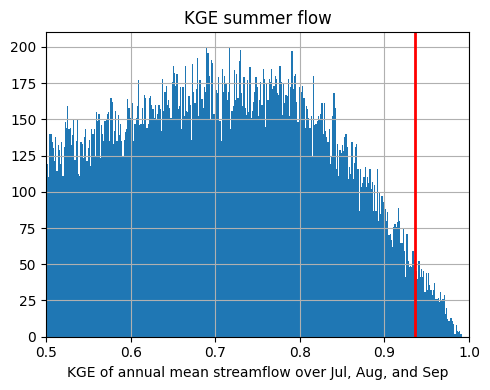

In [10]:
# Pre-calibration on hydrological model

import matplotlib.pyplot as plt
import numpy as np
from src.utils import read_parquet

folder = "component_wise_precalibration_hy"

df_hy = read_parquet(pn.get(folder, "output", "component_wise_precalibration_hy_135334_metrics.parquet"))
df_hy = df_hy.rename(columns={"KGE_G(789)": "KGE summer flow"})
ylist = ["KGE summer flow", 'KGE_C1', 'KGE_C2', 'KGE_G']

# Select top 1% (N=1000)
q99 = np.quantile(df_hy[["KGE summer flow"]], 0.99)
# 0.9367

#% KGE summer flow
fig, ax = plt.subplots(figsize=(5, 4))
df_hy[["KGE summer flow"]].hist(bins=1000, ax=ax)
ax.set_xlim([0.5, 1])
ax.axvline(q99, c="r", lw=2)
#ax.axvline(0.754, c="orange", lw=2, label="Baseline")
ax.set_xlabel("KGE of annual mean streamflow over Jul, Aug, and Sep")
plt.tight_layout()
plt.show()

But why is identifying such a plausible set important?

If we further plot the histogram of the plausible set’s summer flow KGE and compare it to the corresponding flow KGE at gauges C1, C2, and G, we observe differences in the distribution shapes. Because agents interact with different subbasins, these variations in KGE across space may be amplified in the coupled simulations.

C:\Users\CL\AppData\Local\Temp\ipykernel_158280\3624044465.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_hy_plausible[ylist].hist(bins=200, ax=ax)


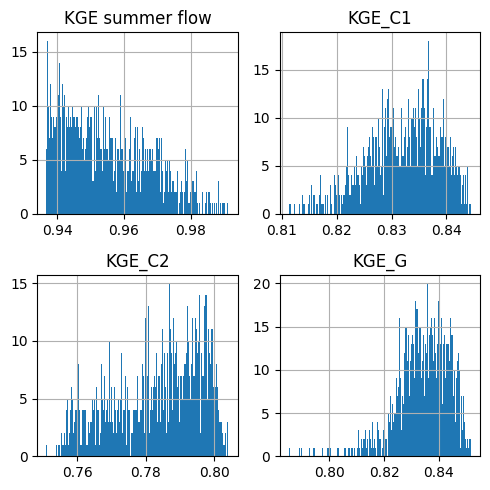

In [11]:
# Histogram of plausible set
df_hy_plausible = df_hy[df_hy["KGE summer flow"] >= q99]
fig, ax = plt.subplots(figsize=(5, 5))
df_hy_plausible[ylist].hist(bins=200, ax=ax)
plt.tight_layout()
plt.show()


### Pre-calibration on ABM

We follow a similar procedure to identify the plausible ABM set, fixing the hydrological parameters to the best-performing set from the previous step. As before, the top 1% of ABMs are defined as plausible.

Similarly, there is substantial variation in agent diversion model performance, even within the narrow range of top 1% summer flow KGE values. Although we did not use KGE values at the agent level to filter plausible models, one can imagine trade-offs in which certain agents perform better than others, stemming from data sampling biases and/or model structural design. Therefore, all models exhibiting such trade-offs should be considered in the analysis to properly acknowledge uncertainty, unless there is a strong justification for favoring one over the others.

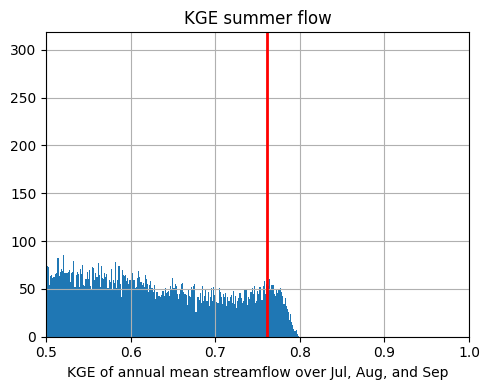

C:\Users\CL\AppData\Local\Temp\ipykernel_158280\1923003742.py:29: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_abm_plausible[ylist].hist(bins=200, ax=ax)


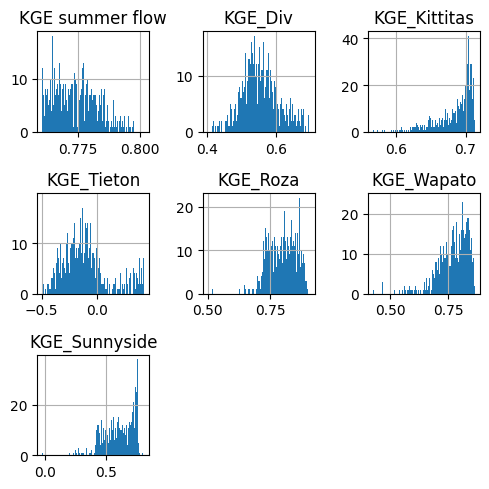

In [12]:
# Precalibration on ABM
import matplotlib.pyplot as plt
import numpy as np
from src.utils import read_parquet

folder = "component_wise_precalibration_abm"

df_abm = read_parquet(pn.get(folder, "output", "component_wise_precalibration_abm_135314_metrics.parquet"))
df_abm = df_abm.rename(columns={"KGE_G(789)": "KGE summer flow"})
ylist = ["KGE summer flow", "KGE_Div", 'KGE_Kittitas', 'KGE_Tieton', 'KGE_Roza', 'KGE_Wapato', 'KGE_Sunnyside']

# Select top 1% (N=1000)
q99 = np.quantile(df_abm[["KGE summer flow"]], 0.99)
# 0.9367

#% KGE summer flow
fig, ax = plt.subplots(figsize=(5, 4))
df_abm[["KGE summer flow"]].hist(bins=1000, ax=ax)
ax.set_xlim([0.5, 1])
ax.axvline(q99, c="r", lw=2)
#ax.axvline(0.754, c="orange", lw=2, label="Baseline")
ax.set_xlabel("KGE of annual mean streamflow over Jul, Aug, and Sep")
plt.tight_layout()
plt.show()


df_abm_plausible = df_abm[df_abm["KGE summer flow"] >= q99]
fig, ax = plt.subplots(figsize=(5, 5))
df_abm_plausible[ylist].hist(bins=200, ax=ax)
plt.tight_layout()
plt.show()

Below, we first select the best-performing model (i.e., the one with the highest KGE) from the plausible hydrological model set and the plausible ABM set to represent the deterministic best for comparison.

In [13]:
# Deterministic solution
df_hy_best_idx = df_hy[df_hy["KGE summer flow"] == df_hy["KGE summer flow"].max()].index[0]
df_abm_best_idx = df_abm[df_abm["KGE summer flow"] == df_abm["KGE summer flow"].max()].index[0]

print("Best hydrological model index (index={}):".format(df_hy_best_idx))
print("Best ABM model index (index={}):".format(df_abm_best_idx))

sample_hy_best = read_parquet(pn.get("component_wise_precalibration_hy", 'samples.parquet')).loc[df_hy_best_idx, :]
sample_abm_best = read_parquet(pn.get("component_wise_precalibration_abm", 'samples.parquet')).loc[df_abm_best_idx, :]
print("Best hydrological model parameters:\n", sample_hy_best)
print("Best ABM model parameters:\n", sample_abm_best)

sol_deterministic = sample_hy_best.values.tolist() + sample_abm_best.values.tolist()
print("Deterministic solution:\n", sol_deterministic)

Best hydrological model index (index=71191):
Best ABM model index (index=83938):
Best hydrological model parameters:
 Alpha|C1     0.009327
Beta|C1      0.051953
Ur|C1       12.895579
Df|C1        0.917720
Alpha|C2     0.031455
Beta|C2      0.280187
Ur|C2       14.891298
Df|C2        0.192161
Alpha|G      0.006282
Beta|G       0.011335
Ur|G         3.653291
Df|G         0.029124
Name: 71191, dtype: float64
Best ABM model parameters:
 Lr_c|Kittitas      0.277226
a|Kittitas       -54.459080
b|Kittitas        61.444570
c|Kittitas        -2.937564
Lr_c|Tieton        0.026969
a|Tieton          -1.000357
b|Tieton           1.879069
c|Tieton           2.900745
Lr_c|Roza          0.116581
a|Roza           -67.628650
b|Roza            71.520592
c|Roza            -4.098586
Lr_c|Wapato        0.073296
a|Wapato         -89.611546
b|Wapato          84.067684
c|Wapato           3.422900
Lr_c|Sunnyside     0.005756
a|Sunnyside        5.554395
b|Sunnyside        1.840722
c|Sunnyside       15.965411
Na

Then, we run the deterministic best simulation.

In [14]:
# Simulate the deterministic best solution
import hydrocnhs
pn.src.add_to_sys_path()
from src.utils import InputBuilder

# Load inputs
folder = "coflow_deterministic_best"
input_file = "inputs_yrb_coupledABM_1979_2023.h5"
inputs_path = pn.get(folder, input_file)
ib = InputBuilder(root_dir)
inputs = ib.load_hdf5(inputs_path)

temp = inputs["temp"]
prec = inputs["prec"]
pet = inputs["pet"]
obv_flow = inputs["obv_flow"]
obv_div = inputs["obv_div"]

# Load model and set the path in the model configuration file
model_path = pn.get(folder, "yrb_coupledABM_GWLF_134742_2.yaml")
model_dict = hydrocnhs.load_model(model_path)
model_dict["Path"]["WD"] = pn.get()
model_dict["Path"]["Modules"] = pn.src.get()

# Assign the parameters to the model configuration

# Create model instance
model = hydrocnhs.Model(model_dict, "coflow_deterministic_best")
#model.paral_setting = {'verbose': 0, 'cores_pet': 1, 'cores_formUH': 1, 'cores_runoff': 1}

# Set assigned_Q
# This is an extra step. Since the reservoir releases are given as inputs, we don't need 
# to simulate the inflows to reservoirs (i.e., discharge of subbasins S1, S2, S3). 
# Therefore, we set the inflows for all reservoirs to zero. 
l = model_dict["WaterSystem"]["DataLength"]
assigned_Q = {sub: [0]*l for sub in ["S1","S2","S3"]}

#%% Run the model
Q = model.run(temp, prec, pet, assigned_Q)
print(Q["G"])

coflow_deterministic_best: 100%|██████████| 16436/16436 [00:05<00:00, 3091.75it/s]


[ 8.4312808  11.38924587 12.43066296 ... 71.08332904 78.18764921
 78.45790385]


The summer KGE is 0.78 according to the calculation below.

In [15]:
# Calculate error metric for the determisnistic best solution
import pandas as pd
sim_Q_D = pd.DataFrame(Q, index=model.pd_date_index)
sim_Q_M = sim_Q_D.resample("MS").mean()
pd_date_M_index = sim_Q_M.index

start_date = '1980-01-01'
end_date = '2023-12-31'
sim_Q_M = sim_Q_M[start_date:end_date]
obv_flow = obv_flow[start_date:end_date]

mask = [True if i.month in [7,8,9] else False for i in sim_Q_M.index]
Q_summer = sim_Q_M[mask].resample("YS").mean()["G"]
indicator = hydrocnhs.Indicator()
kge_g_summer = indicator.get_kge(x_obv=obv_flow[mask].resample("YS").mean()["G"], y_sim=Q_summer, r_na=True)
print("KGE of annual mean streamflow over Jul, Aug, and Sep:", round(kge_g_summer, 2))
Q_summer.rename("G789", inplace=True)
obv_Q_summer = obv_flow[mask].resample("YS").mean()["G"]
obv_Q_summer.rename("obv_G789", inplace=True)

ag_list = ['Kittitas', 'Tieton', 'Roza', 'Wapato', 'Sunnyside']
shortage_M = pd.DataFrame(index=pd_date_M_index)
div_D = pd.DataFrame(index=model.pd_date_index)
for ag in ag_list:
    shortage_M[ag] = model.dc.get_field(ag)["Shortage_M"]
    div_D[ag] = model.dc.get_field(ag)["Div"]
obv_div = obv_div[start_date:end_date]
div_Y = div_D.resample("YS").mean()[start_date:end_date]
div_Y["Div"] = div_Y[ag_list].sum(axis=1)
obv_div_Y = obv_div.resample("YS").mean().sum(axis=1)
obv_div_Y.rename("obv_Div", inplace=True)

df_ts_deterministic_best = pd.concat([Q_summer, obv_Q_summer,div_Y, obv_div_Y], axis=1)
df_ts_deterministic_best.to_csv(pn.get("coflow_deterministic_best", "output") / "deterministic_best_ts.csv")

KGE of annual mean streamflow over Jul, Aug, and Sep: 0.78


Here we show the time series dynamics of summer flow and diversion. Although they do not perfectly match the observations (black dotted line), the overall trends are captured.

But is this sufficient justification for relying on the deterministic best? What might we be missing?

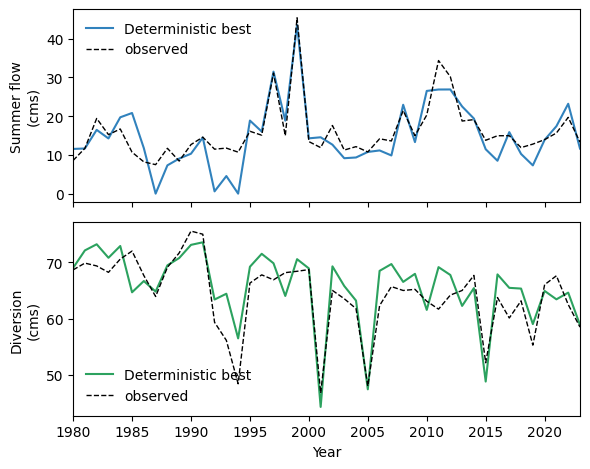

In [16]:
from cmap import Colormap
df_ts_deterministic_best = pd.read_csv(pn.get("coflow_deterministic_best", "output") / "deterministic_best_ts.csv", index_col=0, parse_dates=True)
df_ts_deterministic_best.index = df_ts_deterministic_best.index.year
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), sharex=True)
cm_br = Colormap('colorbrewer:Blues_6')
cm_gr = Colormap('colorbrewer:BuGn_6')

i = 1
colors = [cm_br(i*2+2), cm_gr(i*2+2)]
variables = ['G789', 'Div']  
names = {"G789": "Summer flow\n(cms)", "Div": "Diversion\n(cms)"}
label = "Ensembles"
for ax, col, color in zip(axes, variables, colors):
    # Plot mean line
    ax.plot(df_ts_deterministic_best.index, df_ts_deterministic_best[col], color=color, linestyle='-', label="Deterministic best")
    ax.plot(df_ts_deterministic_best.index, df_ts_deterministic_best["obv_"+col], color="k", linestyle='--', lw=1, label="observed")
    ax.set_ylabel(names[col])
    ax.set_xlim([1980, 2023])

axes[0].legend(frameon=False, fontsize=10)
axes[1].legend(frameon=False, fontsize=10)
# Common X label and title
axes[1].set_xlabel("Year")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

To address this question, we present the histogram of ensemble simulations, where the top 1% of hydrological models and the top 1% of ABMs are combined, resulting in 1,000 × 1,000 = 1,000,000 simulations. A brown vertical line at 0.78 (the summer flow KGE from the deterministic best) is added, and any combined model with KGE ≥ 0.78 is defined as a plausible CoFlow model under the component-wise pre-calibration results.

From this analysis, we find 53,772 combined models that exceed the threshold. This highlights the nonlinear effects of coupling: the component-wise best combination does not necessarily produce the overall best outcome. This is the first limitation of relying solely on the deterministic best.

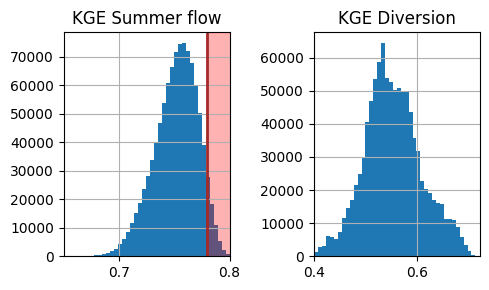

Number of plausible CoFlow models (KGE >= 0.78): 53772
Best summer flow KGE in the ensemble: 0.81


In [17]:
folder = "component_wise_precalibration_hyabm"
df_ensemble = read_parquet(pn.get(folder, "output", "component_wise_precalibration_hyabm_135347_metrics.parquet"))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))

df_ensemble[["KGE_G(789)", "KGE_Div"]].hist(bins=50, ax=axes)

ax = axes[0]
ax.set_title("KGE Summer flow")
ax.axvline(0.78, c="brown", lw=2, label="Deterministic best")
ax.axvspan(0.78, ax.get_xlim()[1], color='red', alpha=0.3)  # shaded region
ax.set_xlim((0.65, 0.8))

ax = axes[1]
ax.set_title("KGE Diversion")
#ax.axvline(0.6, c="r")
#ax.axvspan(0.6, ax.get_xlim()[1], color='red', alpha=0.3)  # shaded region
ax.set_xlim((0.4, 0.72))

plt.tight_layout()
plt.show()

print("Number of plausible CoFlow models (KGE >= 0.78):", sum(df_ensemble["KGE_G(789)"] >= 0.78))
print("Best summer flow KGE in the ensemble:", round(df_ensemble["KGE_G(789)"].max(), 2))

The second limitation we overlook is the uncertainty arising from equifinality, where different parameter sets yield similar performance. In this case, our plausible set has summer flow KGE values ranging from 0.78 to 0.81. As mentioned earlier, each of these models may perform better in one aspect while trading off performance in others. Therefore, as modelers, we aim to present this uncertainty information to provide a more comprehensive picture in our analysis.

We present the time series plot comparing the deterministic best model with the uncertainty band (±2 standard deviations) derived from the plausible model set.

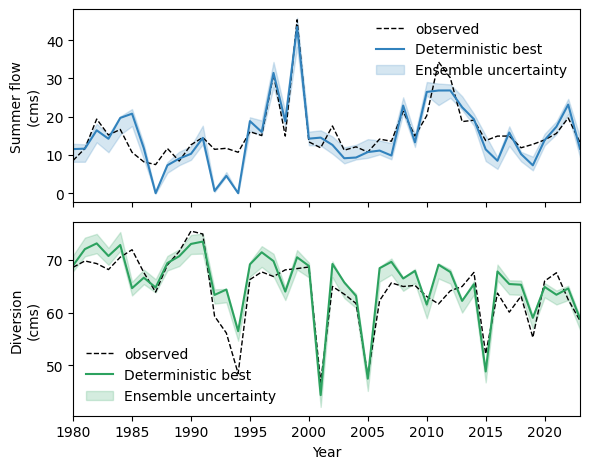

In [18]:
#%% Plot ts uc comparison
df_ts_ensemble = pd.read_parquet(pn.get(folder, "output", "component_wise_precalibration_hyabm_135347_ts_selected.parquet"))
df_ts_ensemble['Year'] = df_ts_ensemble.index.year
df_ts_deterministic_best = pd.read_csv(pn.get("coflow_deterministic_best", "output") / "deterministic_best_ts.csv", index_col=0, parse_dates=True)
df_ts_deterministic_best.index = df_ts_deterministic_best.index.year

from cmap import Colormap
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), sharex=True)
cm_br = Colormap('colorbrewer:Blues_6')
cm_gr = Colormap('colorbrewer:BuGn_6')

i = 1
colors = [cm_br(i*2+2), cm_gr(i*2+2)]
variables = ['G789', 'Div']  
names = {"G789": "Summer flow\n(cms)", "Div": "Diversion\n(cms)"}
label = "Ensembles"
for ax, col, color in zip(axes, variables, colors):
    grouped = df_ts_ensemble.groupby('Year')[col]
    mean = grouped.mean()
    std = grouped.std()
    
    # Plot mean line
    ax.plot(df_ts_deterministic_best.index, df_ts_deterministic_best["obv_"+col], color="k", linestyle='--', lw=1, label="observed")
    ax.plot(df_ts_deterministic_best.index, df_ts_deterministic_best[col], color=color, linestyle='-', label="Deterministic best")
    
    # Plot uncertainty
    lower = mean - 2 * std
    upper = mean + 2 * std
    ax.fill_between(mean.index, lower, upper, alpha=0.2, color=color, label="Ensemble uncertainty")

    ax.set_ylabel(names[col])
    ax.set_xlim([1980, 2023])

axes[0].legend(frameon=False, fontsize=10)
axes[1].legend(frameon=False, fontsize=10)
# Common X label and title
axes[1].set_xlabel("Year")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## B.8.7 Comparison between Component-Wise and Whole-System Pre-Calibration

Compared to the component-wise pre-calibration strategy, the whole-system pre-calibration strategy calibrates both the hydrological and ABM components simultaneously. Specifically, we generate 100,000 LHC samples across the combined hydrological and ABM parameter spaces.

In both strategies, the best summer flow KGE of 0.81 is achieved. However, the component-wise pre-calibration strategy has a higher yield rate in terms of identifying plausible models, as shown in the following code and the CDF plot.

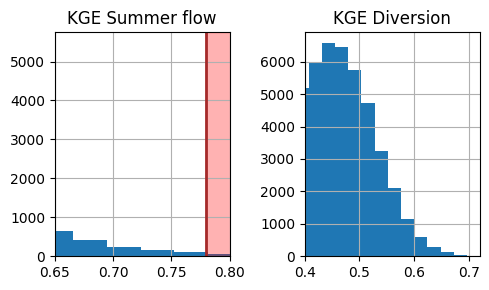

whole system precalibration strategy:
Number of plausible CoFlow models (KGE >= 0.78): 51
Best summer flow KGE: 0.81
Component-wise precalibration strategy:
Number of plausible CoFlow models (KGE >= 0.78): 53772
Best summer flow KGE: 0.81


In [19]:

df_whole = read_parquet(pn.get("whole_system_precalibration", "output", "precali_coupledABM_run_135667_metrics.parquet"))
df_ensemble = read_parquet(pn.get("component_wise_precalibration_hyabm", "output", "component_wise_precalibration_hyabm_135347_metrics.parquet"))


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))

df_whole[["KGE_G(789)", "KGE_Div"]].hist(bins=50, ax=axes)

ax = axes[0]
ax.set_title("KGE Summer flow")
ax.axvline(0.78, c="brown", lw=2, label="Deterministic best")
ax.axvspan(0.78, ax.get_xlim()[1], color='red', alpha=0.3)  # shaded region
ax.set_xlim((0.65, 0.8))

ax = axes[1]
ax.set_title("KGE Diversion")
#ax.axvline(0.6, c="r")
#ax.axvspan(0.6, ax.get_xlim()[1], color='red', alpha=0.3)  # shaded region
ax.set_xlim((0.4, 0.72))

plt.tight_layout()
plt.show()

print("whole system precalibration strategy:")
print("Number of plausible CoFlow models (KGE >= 0.78):", sum(df_whole["KGE_G(789)"] >= 0.78))
print("Best summer flow KGE:", round(df_whole["KGE_G(789)"].max(), 2))

print("Component-wise precalibration strategy:")
print("Number of plausible CoFlow models (KGE >= 0.78):", sum(df_ensemble["KGE_G(789)"] >= 0.78))
print("Best summer flow KGE:", round(df_ensemble["KGE_G(789)"].max(), 2))

C:\Users\CL\AppData\Local\Temp\ipykernel_158280\2173994003.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


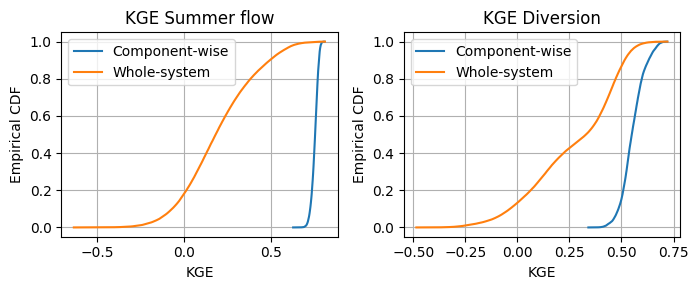

In [20]:
import numpy as np

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

metrics = ["KGE_G(789)", "KGE_Div"]
labels = ["Component-wise", "Whole-system"]
dfs = [df_ensemble, df_whole]
colors = ["tab:blue", "tab:orange"]
titles = ["KGE Summer flow", "KGE Diversion"]

for i, metric in enumerate(metrics):
    ax = axes[i]
    for df, label, color in zip(dfs, labels, colors):
        data = np.sort(df[metric].dropna())
        cdf = np.arange(1, len(data)+1) / len(data)
        ax.plot(data, cdf, label=label, color=color)
    ax.set_title(titles[i])
    ax.set_xlabel("KGE")
    ax.set_ylabel("Empirical CDF")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

Below, we compare the uncertainty information generated from the two pre-calibration strategies. Both approaches produce similar uncertainty ranges, but the whole-system strategy captures more variation, especially in diversion.

This provides important insights for future applications. Although our CoFlow model is complex, it becomes more manageable because we downselected the parameters and parameter ranges for this pre-calibration. We observed a significant decrease in the yield rate of plausible models under the whole-system strategy. This phenomenon is likely to become more pronounced as the problem grows harder (i.e., with larger parameter spaces). In such cases, substantially increasing the number of generated samples would be necessary, which in turn leads to much higher computational costs.

By contrast, the component-wise strategy partitions the parameter space into smaller chunks, reducing the demand for large sample sizes. However, some potential model combinations may be filtered out at the component level, which could lead to underestimating uncertainty. Such trade-offs need to be evaluated case by case: if the parameter space is too large to explore within the available computational resources, the component-wise strategy should be adopted. Otherwise, the whole-system pre-calibration strategy should be considered.


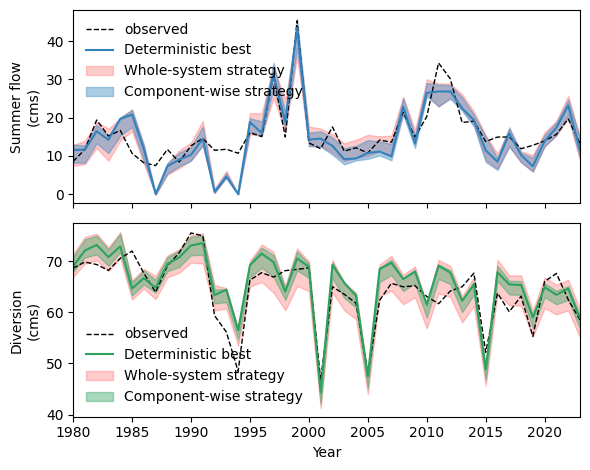

In [21]:
#%% Plot ts uc comparison
df_ts_ensemble = pd.read_parquet(pn.get(r"component_wise_precalibration_hyabm\output", "component_wise_precalibration_hyabm_135347_ts_selected.parquet"))
df_ts_ensemble['Year'] = df_ts_ensemble.index.year

df_ts_whole = pd.read_parquet(pn.get(r"whole_system_precalibration\output", "precali_coupledABM_run_135667_ts_selected.parquet"))
df_ts_whole['Year'] = df_ts_whole.index.year

df_ts_deterministic_best = pd.read_csv(pn.get("coflow_deterministic_best", "output") / "deterministic_best_ts.csv", index_col=0, parse_dates=True)
df_ts_deterministic_best.index = df_ts_deterministic_best.index.year

from cmap import Colormap
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), sharex=True)
cm_br = Colormap('colorbrewer:Blues_6')
cm_gr = Colormap('colorbrewer:BuGn_6')

i = 1
colors = [cm_br(i*2+2), cm_gr(i*2+2)]
variables = ['G789', 'Div']  
names = {"G789": "Summer flow\n(cms)", "Div": "Diversion\n(cms)"}
label = "Ensembles"
for ax, col, color in zip(axes, variables, colors):
    
    
    # Plot mean line
    ax.plot(df_ts_deterministic_best.index, df_ts_deterministic_best["obv_"+col], color="k", linestyle='--', lw=1, label="observed")
    ax.plot(df_ts_deterministic_best.index, df_ts_deterministic_best[col], color=color, linestyle='-', label="Deterministic best")
    
    # Plot uncertainty
    grouped = df_ts_whole.groupby('Year')[col]
    mean = grouped.mean()
    std = grouped.std()
    lower = mean - 2 * std
    upper = mean + 2 * std
    ax.fill_between(mean.index, lower, upper, alpha=0.2, color="red", label="Whole-system strategy")
    
    grouped = df_ts_ensemble.groupby('Year')[col]
    mean = grouped.mean()
    std = grouped.std()
    lower = mean - 2 * std
    upper = mean + 2 * std
    ax.fill_between(mean.index, lower, upper, alpha=0.4, color=color, label="Component-wise strategy")

    ax.set_ylabel(names[col])
    ax.set_xlim([1980, 2023])

axes[0].legend(frameon=False, fontsize=10)
axes[1].legend(frameon=False, fontsize=10)
# Common X label and title
axes[1].set_xlabel("Year")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## B.8.8 Moving in to management metric space

Error metrics such as KGE indicate how well a model reproduces observed data, but they do not necessarily reflect the relevance of model performance to the management problem.
Therefore, we provide a brief analysis of management-oriented metrics as a high-level discussion.

In this tutorial, we focus on the reliability, resilience, and vulnerability (Hashimoto et al., 1982) of flow target violations:

##### 1. Reliability  

Fraction of time the system is in a satisfactory state:

$Rel = N_{satisfactory} / N_{total}$

where:  
- $N_{satisfactory}$ = number of time steps without violation (flow < flow target) 
- $N_{total}$ = total number of evaluated time steps (excluding NaN)  


##### 2. Resilience  

Inverse of the average failure duration:

$Res = 1 / ( (1 / N_f) * Σ_{i=1}^{N_f} D_i )$

where:  
- $N_f$ = number of failure events  
- $D_i$ = duration (in consecutive time steps) of the i-th failure event  
- If no failures, Res = ∞ (or capped value)  


##### 3. Vulnerability  

Average severity of failure events, measured as the mean of maximum deviations per failure episode:

$Vul = (1 / N_f) * Σ_{i=1}^{N_f} ( max_{t ∈ F_i} |x_t - θ| )$

where:  
- $N_f$ = number of failure events  
- $F_i$ = set of time steps in the i-th failure event  
- $x_t$ = system state at time t  
- $θ$ = threshold  
- If no failures, Vul = 0  




In [22]:
# Calculate flow violation metrics
# May take a while to complete
import pandas as pd
from src.utils import reliability, resiliency, vulnerability

# Function to compute violation and shortage metrics
def get_df_vio_shortage(df_ts, df_met, kge_threshold=None):
    df_ts = df_ts.copy()
    df_ts = df_ts[['Violation', 'Shortage', 'global_index']]
    df_met = df_met.copy()

    def compute_metrics_per_group(df_ts, col='Violation'):
        if col == 'Violation':
            failure_operator = "<"
        elif col == 'Shortage':
            failure_operator = ">"

        # Define vectorized function to pass into agg
        def rel(x):
            return reliability(x=x, threshold=0, failure_operator=failure_operator)

        def res(x):
            return resiliency(x=x, threshold=0, failure_operator=failure_operator, cap=float('inf'))

        def vul(x):
            return vulnerability(x=x, threshold=0, failure_operator=failure_operator)

        df_metrics = df_ts.groupby("global_index")[col].agg(
            Reliability=rel,
            Resiliency=res,
            Vulnerability=vul
        ).reset_index()

        return df_metrics

    df_ts_selected = df_ts

    # Apply the function to each group by global_index
    df_vio = compute_metrics_per_group(df_ts_selected, col='Violation')
    df_vio["KGE_G(789)"] = df_met["KGE_G(789)"].values
    df_vio = df_vio[['KGE_G(789)', 'Reliability', 'Resiliency', 'Vulnerability']]

    df_shortage = compute_metrics_per_group(df_ts_selected, col='Shortage')
    df_shortage["KGE_Div"] = df_met["KGE_Div"].values
    df_shortage = df_shortage[['KGE_Div', 'Reliability', 'Resiliency', 'Vulnerability']]
    return df_vio, df_shortage

# Component wise precalibration strategy
df_met_ensemble = pd.read_parquet(pn.get(r"component_wise_precalibration_hyabm\output", "component_wise_precalibration_hyabm_135347_selected_metrics.parquet"))
df_ts_ensemble = pd.read_parquet(pn.get(r"component_wise_precalibration_hyabm\output", "component_wise_precalibration_hyabm_135347_ts_selected.parquet"))

df_vio_ensemble, df_shortage_ensemble = get_df_vio_shortage(df_ts_ensemble, df_met_ensemble)

df_vio_ensemble.to_parquet(pn.get(r"component_wise_precalibration_hyabm\output") / "df_vio_ensemble.parquet")
df_shortage_ensemble.to_parquet(pn.get(r"component_wise_precalibration_hyabm\output") / "df_shortage_ensemble.parquet")

# Whole system precalibration strategy
df_met_whole = pd.read_parquet(pn.get(r"whole_system_precalibration\output", "precali_coupledABM_run_135667_selected_metrics.parquet"))
df_ts_whole = pd.read_parquet(pn.get(r"whole_system_precalibration\output", "precali_coupledABM_run_135667_ts_selected.parquet"))

df_vio_whole, df_shortage_whole = get_df_vio_shortage(df_ts_whole, df_met_whole)

df_vio_whole.to_parquet(pn.get(r"whole_system_precalibration\output") / "df_vio_whole.parquet")
df_shortage_whole.to_parquet(pn.get(r"whole_system_precalibration\output") / "df_shortage_whole.parquet")


Below, we compare the distributions of management metrics with summer flow KGE.

From the figure, it is clear that the distribution shapes of the error metric (KGE Summer Flow) and the management metrics (reliability, resilience, and vulnerability) differ substantially. KGE Summer Flow is more left-skewed, whereas the management metrics follow a distribution closer to Gaussian. This highlights that the error space does not necessarily map linearly to the management space. Therefore, the uncertainty revealed in pre-calibration should not be directly translated into management implications.

Second, a slight shift in KGE Summer Flow corresponds to noticeable shifts in the management metrics, particularly reliability and resilience, even though the overall uncertainty ranges are relatively similar. This finding reinforces the trade-off discussed in the previous section. The component-wise pre-calibration strategy, though more efficient, may filter out candidates that could otherwise fall into the plausible set when combined. Depending on the available computational resources and the complexity of the coupled models, such differences are important for modelers to consider when selecting a pre-calibration strategy.

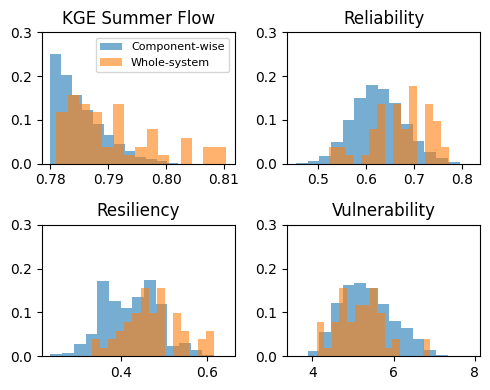

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# List of metrics to compare
metrics = ["KGE_G(789)", "Reliability", "Resiliency", "Vulnerability"]

# Create a figure with 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(5, 4))

for i, col in enumerate(metrics):
    ax = axes[i // 2, i % 2]

    # Normalize counts to 0–1 for each dataset
    weights_ens = np.ones_like(df_vio_ensemble[col]) / len(df_vio_ensemble[col])
    weights_whole = np.ones_like(df_vio_whole[col]) / len(df_vio_whole[col])

    ax.hist(df_vio_ensemble[col], alpha=0.6, bins=15, label="Component-wise", weights=weights_ens)
    ax.hist(df_vio_whole[col], alpha=0.6, bins=15, label="Whole-system", weights=weights_whole)
    if col == "KGE_G(789)":
        col = "KGE Summer Flow"
    ax.set_title(col)
    ax.set_ylim(0, 0.3)   # y-axis normalized to 0–1
    if i == 0:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

## B.8.9 (Optional) Simulation Code

This tutorial aims to give readers an overview of different pre-calibration strategies while minimizing the burden of running the simulations themselves. For those interested in reproducing the results, we provide code for generating LHC samples under the whole-system pre-calibration strategy. Note that the code is designed to run on a high-performance computing system; in our case, the simulations were conducted on Hopper at Cornell.

> Please do not run the code below in this Jupyter notebook. Instead, adapt the code to your own machine.

In [1]:

from IPython.display import display
display("Please do not run the code below in this Jupyter notebook. Instead, adapt the code to your own machine.")
raise SystemExit

import sys
import pathnavigator
from copy import copy
import pandas as pd
import json

# Set working directory
root_dir = "working directory to this repo"
pn = pathnavigator.create(root_dir)
pn.chdir()
from src.utils import YRBModel, InputBuilder

import numpy as np
import pandas as pd
from SALib.sample import latin

# MPI setup for parallel computing
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# job ID
job_id = "00000"
if len(sys.argv) > 1:
    job_id = sys.argv[1]  # Capture the  from the command line

sol = None
inputs = None  # All ranks define 'inputs'
prefix_params = None
samples = None
samples_split = None
global_index_list = None
global_index_list_split = None
baseline_M = None
baseline_Y = None
folder = f"whole_system_precalibration_simulation_{job_id}"
if rank == 0:
    baseline_M = pd.read_parquet(pn.whole_system_precalibration_simulation.data.baseline.get() / "baseline_M.parquet")
    baseline_Y = pd.read_parquet(pn.whole_system_precalibration_simulation.data.baseline.get() / "baseline_Y.parquet")

    pn.mkdir("outputs", folder)
    pn.mkdir(f"{folder}/out")
    pn.mkdir(f"{folder}/out_parquet")

    input_file = "inputs_yrb_coupledABM_1979_2023.h5"
    inputs_path = pn.whole_system_precalibration_simulation.inputs.get(input_file)
    ib = InputBuilder(root_dir)
    inputs = ib.load_hdf5(inputs_path)

    bounds = []
    # Parameter bounds for hydrological model
    bounds += [
        [0, 0.03], [0.047-0.015, 0.047+0.015], [12.97-0.7, 12.97+0.7], [0.9, 1],
        [0.038-0.015, 0.038+0.015], [0.289-0.015, 0.289+0.015], [13.6, 15], [0.191-0.05, 0.191+0.05],
        [0.019-0.015, 0.019+0.015], [0, 0.03], [3.534-0.7, 3.534+0.7], [0, 0.1],
        ]
    # Parameter bounds for ABM
    bounds += [[0, 0.6], [-57.641, -50.941], [56.928, 63.628], [-2.975, -2.675],
               [0, 0.6], [-1.05, -0.95], [1.79, 1.89], [2.741, 3.041],
               [0, 0.6], [-72.877, -66.677], [68.65, 75.15], [-4.109, -3.709],
               [0, 0.6], [-92.231, -84.931], [82.508, 89.808], [3.327, 3.727],
               [0, 0.6], [5.511, 6.011], [1.766, 1.866], [14.817, 16.217]]

    # Parameter names
    par_names = []
    for sub in ["C1", "C2", "G"]:
        par_names += [f"Alpha|{sub}", f"Beta|{sub}", f"Ur|{sub}", f"Df|{sub}"]
    for agt in ["Kittitas", "Tieton", "Roza", "Wapato", "Sunnyside"]:
        par_names += [f"Lr_c|{agt}", f"a|{agt}", f"b|{agt}", f"c|{agt}"]

    # problem dict for SALib
    problem = {
        'num_vars': len(par_names),
        'names': par_names,
        'bounds': bounds
    }

    # Generate LHC samples
    N = 100_000
    samples = latin.sample(problem, N)
    global_index_list = np.arange(N)

    # Save samples and problem definition
    df_samples = pd.DataFrame(samples, columns=problem['names'])
    df_samples.to_parquet(pn.outputs.get(folder) / 'samples.parquet')
    with open(pn.outputs.get(folder) / 'problem.json', 'w') as f:
        json.dump(problem, f, indent=2)

    # Split samples for each rank
    samples_split = np.array_split(samples, size)
    global_index_list_split = np.array_split(global_index_list, size)

    # Predefined solution vector from the calibration for this tutorial
    sol = [ # Runoff parameters
        57.806684557214766, 0.20921822186571032, 0.0021252100154348186, 0.07555413725479335,
        0.0078315153292290215, 0.047269021191585818, 12.973464082495669, 0.99811260401725921,
        0.50323414523618315, 40.10654271622753, 0.451986581515048, 0.13104710284265361,
        0.24464289762623362, 0.038305348232977939, 0.28860239710605301, 14.964614050102517,
        0.1905496877586714, 0.50247349013414366, 97.943484278473164, 0.0058089898829584794,
        0.0013708525375180976, 0.025723631383318582, 0.019412243955173984, 0.008901690014376545,
        3.5338621559998837, 0.031755551265759754, 0.63811569315262018
        ]

    sol += [ # rounting parameters
        4.9542084701678046,
        2075.7210341296063, 41.756237952563971, 300.5645982306533, 1.2123677418635574,
        62.204640137243139, 25.544907902576831, 1176.409479661482, 13.257064083797713,
        24.487283957419237, 1.6959902065234733, 3797.5650981325298, 3.7618274882121145,
        4294.0006716313274, 8.215939729315872, 138.05160578705724
        ]

    sol += [ # div factor
        -0.5100900170661984,
        0.4999942363986448
        ]

    sol += [ # ABM
        # [f"L_U|{agt}", f"L_L|{agt}", f"Lr_c|{agt}", f"Sig|{agt}", f"a|{agt}", f"b|{agt}", f"c|{agt}", f"ProratedRatio|{agt}"]
        3.73169576e+01,  1.20901067e+01,  5.35765712e-01,  3.64858422e-06, -5.42912204e+01,  6.02780942e+01, -2.82451838e+00,  7.54912269e-01,
        2.52000376e+01,  7.98968791e+00,  4.19598126e-02,  3.48147050e-02, -1.00014462e+00,  1.84007557e+00,  2.89074562e+00,  9.99999939e-01,
        3.12282426e+01,  7.03747502e+00,  1.87497446e-01,  3.44091335e-05, -6.97768206e+01,  7.18995291e+01, -3.90853895e+00,  7.58899236e-01,
        4.00906766e+01,  3.43028776e-01,  6.40280352e-02,  1.39443695e-01, -8.85807016e+01,  8.61580001e+01,  3.52698613e+00,  8.21612634e-01,
        4.99973348e+01,  4.07236213e+00,  1.05478177e-01,  1.99227545e-02,  5.76079826e+00,  1.81599306e+00,  1.55166783e+01,  8.86226600e-01
        ]

# ==== BROADCAST INPUTS AND SCATTER SAMPLES ====
sol = comm.bcast(sol, root=0)
inputs = comm.bcast(inputs, root=0)
prefix_params = comm.bcast(prefix_params, root=0)
baseline_M = comm.bcast(baseline_M, root=0)
baseline_Y = comm.bcast(baseline_Y, root=0)
rank_samples = comm.scatter(samples_split, root=0)
global_indexes = comm.scatter(global_index_list_split, root=0)

#%%#####################################################################################

sample = []
for agt in ['Kittitas', 'Tieton', 'Roza', 'Wapato', 'Sunnyside']:
    sample += [f"Lr_c|{agt}", f"a|{agt}", f"b|{agt}", f"c|{agt}"]

def sim_func(global_index, sample):
    func = YRBModel.coupledABM_func(
        pn=pn,
        inputs=inputs,
        model_file="yrb_coupledABM_GWLF_134742_2.yaml",
        disable=True,
        get_model=False,
        get_model_dict=False,
        mode="sa",
        seeds=[1],
        baseline_M=baseline_M,
        baseline_Y=baseline_Y,
        )

    params = copy(sol)  # Copy the solution vector
    for i in range(3):  # Update runoff parameters
        params[4+9*i], params[5+9*i], params[6+9*i], params[7+9*i] = sample[i*4:i*4+4]
    for i in range(5):
        params[47+i*8], params[49+i*8], params[50+i*8], params[51+i*8] = sample[i*4+12:i*4+16]  # Update ABM parameters

    met_dict_all, df_M_all = func(*params)

    # Save metrics to json
    with open(pn.outputs.get(folder) / 'out' / f'Y_{int(global_index)}.json', 'w') as f:
        json.dump(met_dict_all, f, indent=2)

    # Conservation policy
    a, b = 0.0992, 10
    x = np.arange(39)
    policy = [b]*5 + list(a*x+b)

    # Processing time series results and save to parquet
    for seed, df_M in df_M_all.items():
        mask = [True if i.month in [7,8,9] else False for i in df_M.index]

        df_Y = [
            df_M.loc[mask, ['G']].resample("YS").mean().rename(columns={'G': 'G789'}),
            df_M[['Kittitas_shortage', 'Tieton_shortage', 'Roza_shortage', 'Wapato_shortage', 'Sunnyside_shortage']].resample("YS").sum(),
            df_M[['Kittitas', 'Tieton', 'Roza', 'Wapato', 'Sunnyside']].resample("YS").mean(),
            ]
        df_Y = pd.concat(df_Y, axis=1)
        df_Y["Div"] = df_Y[['Kittitas', 'Tieton', 'Roza', 'Sunnyside', 'Wapato']].sum(axis=1)
        df_Y["Violation"] = df_Y['G789'] - policy
        df_Y["Shortage"] = df_Y[['Kittitas_shortage', 'Tieton_shortage', 'Roza_shortage', 'Wapato_shortage', 'Sunnyside_shortage']].sum(axis=1)
        df_Y["global_index"] = global_index
        df_Y["seed"] = seed

        df_Y.to_parquet(pn.outputs.get(folder) / 'out_parquet' / f'Y_{int(global_index)}_{seed}.parquet')
    return None

#%%#####################################################################################
# ==== RUN SIMULATIONS SERIALLY WITHIN RANK ====
results = []
for global_index, sample in zip(global_indexes, rank_samples):
    met_dict = sim_func(global_index, sample)

# ==== SYNCHRONIZE RANKS ====
comm.Barrier()

MPI.Finalize()

'Please do not run the code below in this Jupyter notebook. Instead, adapt the code to your own machine.'

SystemExit: 

c:\Users\CL\miniconda3\envs\yrb\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## References
Gupta, H. V., Kling, H., Yilmaz, K. K., & Martinez, G. F. (2009). Decomposition of the mean squared error and NSE performance criteria: Implications for improving hydrological modelling. Journal of Hydrology, 377(1–2), 80–91. https://doi.org/10.1016/j.jhydrol.2009.08.003

Haith, D. A., & Shoemaker, L. L. (1987). Generalized watershed loading functions for stream flow nutrients. Journal of the American Water Resources Association, 23(3), 471–478. https://doi.org/10.1111/j.1752-1688.1987.tb00825.x

Lin, C., & Yang, Y. E. (2022). The effects of model complexity on model output uncertainty in co‐evolved coupled natural‐human systems. Earth’s Future, 10(6), e2021EF002403. https://doi.org/10.1029/2021EF002403

Lohmann, D., Raschke, E., Nijssen, B., & Lettenmaier, D. P. (1998). Regional scale hydrology: I. Formulation of the VIC-2L model coupled to a routing model. Hydrological Sciences Journal, 43(1), 131–141. https://doi.org/10.1080/02626669809492107

Tung, C. P., & Haith, D. A. (1995). Global-warming effects on New York streamflows. Journal of Water Resources Planning and Management, 121(2), 216–225. https://doi.org/10.1061/(ASCE)0733-9496(1995)121:2(216)

Wi, S., Yang, Y. C. E., Steinschneider, S., Khalil, A., & Brown, C. M. (2015). Calibration approaches for distributed hydrologic models in poorly gaged basins: Implication for streamflow projections under climate change. Hydrology and Earth System Sciences, 19(2), 857–876. https://doi.org/10.5194/hess-19-857-2015